In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
import time

from torchtext import data
from torchtext import datasets

import urllib.request

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


import spacy

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
TEXT = data.Field(tokenize = 'spacy')

fields = [(None, None),(None, None),('overview',TEXT)]
train_text, valid_text, test_text = data.TabularDataset.splits(
                                        path = '',
                                        train = '/content/drive/My Drive/YSU_Masters/CS229_movie/X_train.csv',
                                        validation = '/content/drive/My Drive/YSU_Masters/CS229_movie/X_val.csv',
                                        test = '/content/drive/My Drive/YSU_Masters/CS229_movie/X_test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

In [0]:
MAX_VOCAB_SIZE = len(overview_dictionary)

TEXT.build_vocab(train_text, 
                 max_size = MAX_VOCAB_SIZE)

print(vars(train_text.examples[0]))

print(vars(TEXT.vocab)['stoi'])

In [0]:
device = "cuda:0"
train_iterator = data.BucketIterator(
    train_text, 
    batch_size = train_data.shape[0],
    device = device,
    shuffle = False)

for batch in train_iterator:
  train_text_indices = batch.overview.permute(1, 0)
  print(train_text_indices.shape)

valid_iterator = data.BucketIterator(
    valid_text, 
    batch_size = valid_data.shape[0],
    device = device,
    shuffle = False)

for batch in valid_iterator:
  valid_text_indices = batch.overview.permute(1, 0)
  print(valid_text_indices.shape)

  
test_iterator = data.BucketIterator(
    test_text, 
    batch_size = test_data.shape[0],
    device = device,
    shuffle = False)

for batch in test_iterator:
  test_text_indices = batch.overview.permute(1, 0)
  print(test_text_indices.shape)

In [0]:
l = list(map(vars(TEXT.vocab)['stoi'].get, vars(train_text.examples[0])['overview']))

max_l = max(train_text_indices.shape[1], valid_text_indices.shape[1], test_text_indices.shape[1])

train_text_indices = np.ones((train_data.shape[0],max_l), dtype = int)
valid_text_indices = np.ones((valid_data.shape[0],max_l), dtype = int)
test_text_indices = np.ones((test_data.shape[0],max_l), dtype = int)

for i in range(train_data.shape[0]):
  l = list(map(vars(TEXT.vocab)['stoi'].get, vars(train_text.examples[i])['overview']))
  train_text_indices[i,:len(l)] = l

for i in range(valid_data.shape[0]):
  l = list(map(vars(TEXT.vocab)['stoi'].get, vars(valid_text.examples[i])['overview']))
  valid_text_indices[i,:len(l)] = l
  
for i in range(test_data.shape[0]):
  l = list(map(vars(TEXT.vocab)['stoi'].get, vars(test_text.examples[i])['overview']))
  test_text_indices[i,:len(l)] = l
  
print(train_text_indices.shape)
print(valid_text_indices.shape)
print(test_text_indices.shape)

# NN

In [0]:
RANDOM_SEED = 1
BATCH_SIZE = 128
DEVICE = "cuda:0"

In [0]:
class PosterDataset(Dataset):
    def __init__(self, csv_path, text, transform=None):
        df = pd.read_csv(csv_path)
        self.text = text
        self.y = df['imdb_score'].values
        self.others = df.drop(columns = ['posterID','imdb_score'])

    def __getitem__(self, index):
        return self.y[index], self.others.values[index], self.text[index]
      
    def __len__(self):
        return self.y.shape[0]

In [57]:
custom_transform = transforms.Compose([transforms.Resize([224,224]),                        
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = PosterDataset(csv_path='/content/drive/My Drive/YSU_Masters/CS229_movie/train_final.csv',
                              text = train_text_indices,
                              transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=0)

val_dataset = PosterDataset(csv_path='/content/drive/My Drive/YSU_Masters/CS229_movie/val_final.csv',
                             text = val_text_indices,
                             transform=custom_transform)

val_loader = DataLoader(dataset=val_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=0)

test_dataset = PosterDataset(csv_path='/content/drive/My Drive/YSU_Masters/CS229_movie/test_final.csv',
                             text = test_text_indices,
                             transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=0)



for labels, others, text in train_loader:  
    print('Labels dimensions:', labels.shape)
    print('Others dimensions:', others.shape)
    print('Text dimensions:', text.shape)
    break

for labels, others, text in val_loader:  
    print('Labels dimensions:', labels.shape)
    print('Others dimensions:', others.shape)
    print('Text dimensions:', text.shape)
    break

for labels, others, text in test_loader:  
    print('Labels dimensions:', labels.shape)
    print('Others dimensions:', others.shape)
    print('Text dimensions:', text.shape)
    break


Labels dimensions: torch.Size([128])
Others dimensions: torch.Size([128, 5908])
Text dimensions: torch.Size([128, 1])
Labels dimensions: torch.Size([128])
Others dimensions: torch.Size([128, 5908])
Text dimensions: torch.Size([128, 1])
Labels dimensions: torch.Size([128])
Others dimensions: torch.Size([128, 5908])
Text dimensions: torch.Size([128, 1])


In [0]:
# !unzip "/content/drive/My Drive/YSU_Masters/CS229_movie/posters.zip"

In [0]:
def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for labels, others, text in data_loader:
            others = others.to(DEVICE)
            labels = labels.to(DEVICE)
            text = text.to(DEVICE)
            preds = model(others, text)

            loss = torch.sum((preds - labels)**2)
            num_examples += labels.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [0]:
def train(model, train_loader, valid_loader, num_epochs):

    train_epoch_cost  = []
    valid_epoch_cost  = []
    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (labels, others, text) in enumerate(train_loader):

            others = others.to(DEVICE)
            labels = labels.to(DEVICE)
            text = text.to(DEVICE)
            preds = model(others, text)

            cost = torch.mean((preds - labels)**2)
            optimizer.zero_grad()

            cost.backward()

            optimizer.step()
  
        with torch.set_grad_enabled(False): 
            
            train_cost = compute_epoch_loss(model, train_loader)
            valid_cost = compute_epoch_loss(model, valid_loader)
            print('Epoch: %03d/%03d | Train: %.3f | Valid: %.3f' % (
                  epoch+1, num_epochs, 
                  train_cost,
                  valid_cost))
            train_epoch_cost.append(train_cost)
            valid_epoch_cost.append(valid_cost)
            if valid_cost < 0.87:
              break

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    with torch.set_grad_enabled(False):
        print('Valid accuracy: %.2f%%' % (compute_epoch_loss(model, valid_loader)))
        
    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return train_epoch_cost, valid_epoch_cost

## FC

In [0]:
val_final = pd.read_csv('/content/drive/My Drive/YSU_Masters/CS229_movie/val_final.csv', encoding='latin1')

In [0]:
NUM_FEATURES = val_final.shape[1] - 2
LEARNING_RATE = 0.0001


In [77]:
NUM_FEATURES

5908

In [0]:
class FC(nn.Module):

    def __init__(self, num_features):
        super(FC, self).__init__()
        
        self.linear1 = nn.Linear(num_features, num_features*2)
        self.linear2 = nn.Linear(num_features*2, num_features*2)
        self.linear3 = nn.Linear(num_features*2, num_features*2)
        self.linear4 = nn.Linear(num_features*2, num_features*2)
        self.linear5 = nn.Linear(num_features*2, 1)

        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.5)

    def forward(self, others, text):
        
        out = self.linear1(others.float())
        out = F.relu(out)
        #out = self.dropout1(out)

        out = self.linear2(out)
        out = F.relu(out)
        #out = self.dropout2(out)

        out = self.linear3(out)
        out = F.relu(out)
        #out = self.dropout3(out)

        out = self.linear4(out)
        out = F.relu(out)
        #out = self.dropout4(out)

        out = self.linear5(out)
        
        return out.view(-1)
      
torch.manual_seed(0)

fc = FC(NUM_FEATURES)
fc.to(DEVICE)

optimizer = torch.optim.Adam(fc.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

Epoch: 001/100 | Train: 1.562 | Valid: 1.568
Time elapsed: 0.61 min
Epoch: 002/100 | Train: 1.551 | Valid: 1.570
Time elapsed: 1.23 min
Epoch: 003/100 | Train: 1.194 | Valid: 1.232
Time elapsed: 1.85 min
Epoch: 004/100 | Train: 1.112 | Valid: 1.198
Time elapsed: 2.47 min
Epoch: 005/100 | Train: 1.073 | Valid: 1.138
Time elapsed: 3.09 min
Epoch: 006/100 | Train: 1.561 | Valid: 1.647
Time elapsed: 3.70 min
Epoch: 007/100 | Train: 1.523 | Valid: 1.631
Time elapsed: 4.32 min
Epoch: 008/100 | Train: 0.975 | Valid: 1.076
Time elapsed: 4.94 min
Epoch: 009/100 | Train: 1.239 | Valid: 1.353
Time elapsed: 5.56 min
Epoch: 010/100 | Train: 1.206 | Valid: 1.337
Time elapsed: 6.18 min
Epoch: 011/100 | Train: 1.055 | Valid: 1.200
Time elapsed: 6.79 min
Epoch: 012/100 | Train: 0.899 | Valid: 1.062
Time elapsed: 7.41 min
Epoch: 013/100 | Train: 1.013 | Valid: 1.160
Time elapsed: 8.03 min
Epoch: 014/100 | Train: 0.891 | Valid: 1.074
Time elapsed: 8.65 min
Epoch: 015/100 | Train: 0.831 | Valid: 1.050
Tim

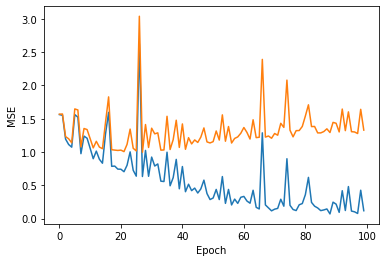

In [68]:
train_epoch_cost, val_epoch_cost = train(fc, train_loader, val_loader, 100)

plt.plot(range(len(train_epoch_cost)), train_epoch_cost)
plt.plot(range(len(val_epoch_cost)), val_epoch_cost)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

In [69]:
print(compute_epoch_loss(fc, test_loader))

tensor(1.3053, device='cuda:0', dtype=torch.float64)


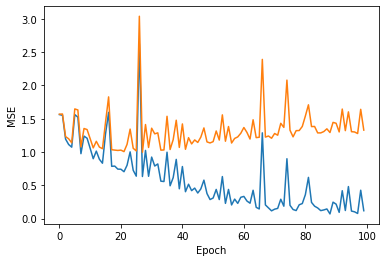

In [74]:
plt.plot(range(len(train_epoch_cost)), train_epoch_cost)
plt.plot(range(len(val_epoch_cost)), val_epoch_cost)
plt.ylabel('MSE')
plt.xlabel('Epoch')

plt.savefig('/content/drive/My Drive/YSU_Masters/CS229_movie/NN_mse.png')
